# Radar access with python-awips

In [25]:
from datetime import datetime
from datetime import timedelta

from awips.dataaccess import DataAccessLayer
from awips import ThriftClient
import radar_common

from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from dynamicserialize.dstypes.com.raytheon.uf.common.dataplugin.level import Level
from dynamicserialize.dstypes.com.raytheon.uf.common.dataplugin.radar.request import GetRadarDataRecordRequest
import numpy as np

    
def encode_data(yLen, xLen, array):
    nxy = yLen*xLen
    j = 0
    msg = ""
    while j<nxy :
        i = 0
        while i<xLen :
            if array[i+j]<0 :
                msg += str(256+array[i+j]) + " "
            else :
                msg += str(array[i+j]) + " "
            i += 1
        msg += "\n"
        j += xLen
    return msg[0:-1]


# EDEXIngest /data_store/radar/FTG/DHR/SDUS55_FTG_DHR_151639_426761196.rad 
dateTimeStr = "2016-03-15 16:48"
slop = 300
client = ThriftClient.ThriftClient("edex-cloud.unidata.ucar.edu")
dateTime = datetime.strptime(dateTimeStr, "%Y-%m-%d %H:%M")
beginRange = dateTime - timedelta(0, slop)
endRange = dateTime + timedelta(0, slop)
timerange = TimeRange(beginRange, endRange)
#print "Requesting ", beginRange, "to", endRange

# Perform a GetRadarHDF5Request
request = GetRadarDataRecordRequest()
# must be lower case here
request.setRadarId("kftg")
request.setPrimaryElevationAngle("0.5")
request.setProductCode(94)
request.setTimeRange(timerange)
response = client.sendRequest(request)

if response.getData():
    for record in response.getData():
        idra = record.getHdf5Data()
        rdat,azdat,depVals,threshVals = radar_common.get_hdf5_data(idra)

        dim = rdat.getDimension()
        yLen = rdat.getSizes()[0]
        xLen = rdat.getSizes()[1]
        # byte[] -- the raw data
        array = rdat.getByteData()
        arraySize = len(array)
        # get data for azimuth angles if we have them.
        if azdat :
            azVals = azdat.getFloatData()
            azValsLen = len(azVals)
        #msg = radar_common.get_header(record, format, xLen, yLen, azdat, "description")
        header = radar_common.get_header(record, format, xLen, yLen, azdat, "description")
        print "record.getDataTime()              =",record.getDataTime()
        print "record.getLongitude()             =",record.getLongitude()
        print "record.getLatitude()              =",record.getLatitude()
        print "record.getElevation()             =",record.getElevation()
        print "record.getElevationNumber()       =",record.getElevationNumber()
        print "record.getTrueElevationAngle()    =",record.getTrueElevationAngle()
        print "record.getVolumeCoveragePattern() =",record.getVolumeCoveragePattern()
        dattyp = radar_common.get_data_type(azdat)
        radialArray = np.array(radar_common.encode_radial(azVals))
        print radialArray.shape
        print rng.shape
        print radialArray
        rng = np.linspace(0, xLen, xLen + 1)
        print rng
        print rng[200]
        #print radar_common.encode_dep_vals(depVals)
        #print radar_common.encode_thresh_vals(threshVals)
        print "radar_common.get_data_type(azdat)  =", dattyp
        print "xLen =",xLen
        print "yLen =", yLen
        #print header

        #msg += radar_common.encode_thresh_vals(threshVals)
        #msg += radar_common.encode_dep_vals(depVals)
        #if azdat :
        #    msg += radar_common.encode_radial(azVals)
        #msg += encode_data(yLen, xLen, radialArray)
        #print msg


record.getDataTime()              = 2016-03-15 16:48:22
record.getLongitude()             = -104.546
record.getLatitude()              = 39.786
record.getElevation()             = 5610.0
record.getElevationNumber()       = 1
record.getTrueElevationAngle()    = 0.5
record.getVolumeCoveragePattern() = 32
(360,)
(1201,)
[ 230.  231.  232.  233.  234.  235.  236.  237.  238.  239.  240.  241.
  242.  243.  244.  245.  246.  247.  248.  249.  250.  251.  252.  253.
  254.  255.  256.  257.  258.  259.  260.  261.  262.  263.  264.  265.
  266.  267.  268.  269.  270.  271.  272.  273.  274.  275.  276.  277.
  278.  279.  280.  281.  282.  283.  284.  285.  286.  287.  288.  289.
  290.  291.  292.  293.  294.  295.  296.  297.  298.  299.  300.  301.
  302.  303.  304.  305.  306.  307.  308.  309.  310.  311.  312.  313.
  314.  315.  316.  317.  318.  319.  320.  321.  322.  323.  324.  325.
  326.  327.  328.  329.  330.  331.  332.  333.  334.  335.  336.  337.
  338.  339.  340.  341.

max range 460.0
(361,)
(461,)
max range 300.0
(361,)
(1201,)


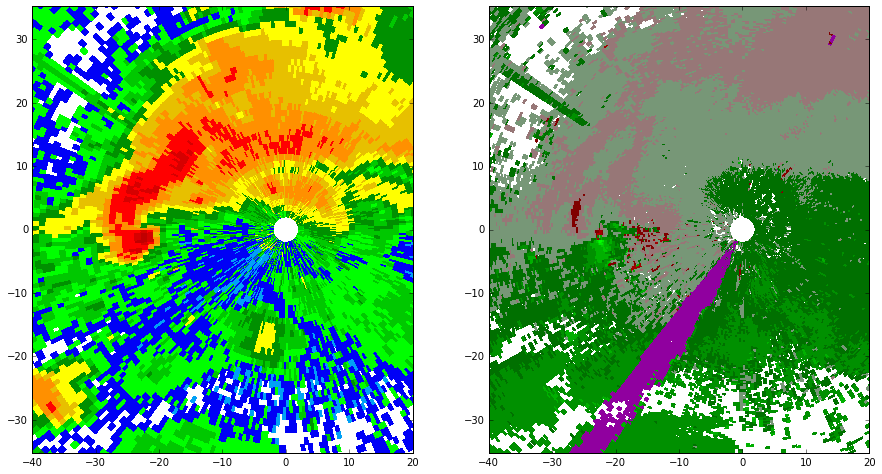

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import ma

from metpy.cbook import get_test_data
from metpy.io.nexrad import Level3File
from metpy.plots import ctables

%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
for v, ctable, ax in zip(('N0Q', 'N0U'), ('NWSReflectivity', 'NWSVelocity'), axes):
    # Open the file
    name = get_test_data('nids/KOUN_SDUS54_%sTLX_201305202016' % v, as_file_obj=False)
    f = Level3File(name)

    # Pull the data out of the file object
    datadict = f.sym_block[0][0]

    # Turn into an array, then mask
    data = ma.array(datadict['data'])
    data[data==0] = ma.masked

    # Grab azimuths and calculate a range based on number of gates
    #print datadict['start_az']
    #print datadict['end_az']
    az = np.array(datadict['start_az'] + [datadict['end_az'][-1]])
    rng = np.linspace(0, f.max_range, data.shape[-1] + 1)
    #print v, data.shape
    print "max range", f.max_range
    print az.shape
    print rng.shape
    # Convert az,range to x,y
    xlocs = rng * np.sin(np.deg2rad(az[:, np.newaxis]))
    ylocs = rng * np.cos(np.deg2rad(az[:, np.newaxis]))
    
 
   
    # Plot the data
    norm, cmap = ctables.registry.get_with_steps(ctable, 16, 16)
    ax.pcolormesh(xlocs, ylocs, data, norm=norm, cmap=cmap)
    ax.set_aspect('equal', 'datalim')
    ax.set_xlim(-40, 20)
    ax.set_ylim(-30, 30)

plt.show()